In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.covariance import GraphicalLasso
from tqdm.auto import tqdm

plt.style.use('ggplot')

/home/mlauber/miniconda3/envs/mci_mri_graph/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


No bootstrapping on this either so will need to combine into one notebook

Something about the a4 datasets is making this ill coniditoned for the solver/breaking figure it out
adni data seems fine tho 

In [2]:
data = pd.read_csv("construct_ggm/pet_graphs/adni/adni_amy_tau_merged_cent_high_quartile.csv",index_col=0)
data.sample(3)

,SUPRAMARGINAL,AMYGDALA,MIDDLETEMPORAL,PARSOPERCULARIS,CAUDALANTERIORCINGULATE,INSULA,MEDIALORBITOFRONTAL,ENTORHINAL,PUTAMEN,PERICALCARINE,...,POSTERIORCINGULATE,SUPERIORTEMPORAL,FUSIFORM,PARACENTRAL,CEREBELLUM_CORTEX,PARAHIPPOCAMPAL,BANKSSTS,POSTCENTRAL,HIPPOCAMPUS,SUPERIORFRONTAL
RID,,,,,,,,,,,,,,,,,,,,,
6683,4.076,1.397,4.528,3.134,0.702,1.261,1.297,1.865,2.039,0.791,...,3.147,2.620,3.644,1.379,0.992,2.015,5.050,1.867,1.405,2.467
6100,2.503,2.853,2.523,2.297,1.793,1.938,2.073,2.338,1.927,1.320,...,2.320,1.798,2.048,1.211,1.015,2.406,2.808,1.520,1.832,2.515
4862,1.530,2.136,1.949,1.468,1.239,1.366,1.491,2.504,2.113,1.225,...,1.341,1.652,1.855,1.293,0.985,1.857,1.667,1.340,1.498,1.494


In [3]:
# #for instance figure out exactly what data I want to do this on (both these versions have hippocampus)
# data = pd.read_csv("construct_ggm/pet_graphs/a4/a4_amy_tau_merged_cent_low_quartile.csv",index_col=0)
# data.sample(3)

In [4]:
print(data["CENTILOIDS"])

RID
555     114.0
626     123.0
731     157.0
800     121.0
2068    133.0
        ...  
6512    138.0
6535    139.0
6572    115.0
6580    142.0
7105    112.0
Name: CENTILOIDS, Length: 99, dtype: float64


In [5]:
#drop centiloids
data = data.drop(columns="CENTILOIDS")

In [6]:
# data = pd.read_csv("construct_ggm/pet_graphs/amy_pos_reg_dropleftright.csv",index_col=0)
# data.sample(3)

In [7]:
scaler = StandardScaler()
scaler.set_output(transform='pandas')

data_scaled = scaler.fit_transform(data)

In [8]:
model = GraphicalLasso(alpha=0.6, 
                       max_iter=100, 
                       tol=1e-2, 
                       mode='cd',
                       assume_centered=True)

model.fit(data_scaled)

GraphicalLasso(alpha=0.6, assume_centered=True, tol=0.01)

In [9]:
alphas = np.linspace(0.05,1.,128)
precision_nonzero = []
covariance_nonzero = []
log_likelihoods = []

n_features = len(data_scaled.columns)
n_samples = len(data_scaled)

for alpha in tqdm(alphas): 
    
    model = GraphicalLasso(alpha=alpha, max_iter=1000, tol=1e-3, mode='cd', eps=1e-6, assume_centered=True)
    model.fit(data_scaled)

    log_likelihoods.append(model.score(data_scaled))
    precision_nonzero.append(np.count_nonzero(model.precision_))
    covariance_nonzero.append(np.count_nonzero(model.covariance_))

log_likelihoods = np.array(log_likelihoods)
precision_nonzero = np.array(precision_nonzero)
covariance_nonzero = np.array(covariance_nonzero)

  0%|          | 0/128 [00:00<?, ?it/s]/home/mlauber/miniconda3/envs/mci_mri_graph/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:183: ConvergenceWarning: graphical_lasso: did not converge after 1000 iteration: dual gap: -2.090e-02
  warnings.warn(
  2%|▏         | 2/128 [00:02<02:55,  1.40s/it]/home/mlauber/miniconda3/envs/mci_mri_graph/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:183: ConvergenceWarning: graphical_lasso: did not converge after 1000 iteration: dual gap: -3.451e-02
  warnings.warn(
  2%|▏         | 3/128 [00:05<04:05,  1.96s/it]/home/mlauber/miniconda3/envs/mci_mri_graph/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:183: ConvergenceWarning: graphical_lasso: did not converge after 1000 iteration: dual gap: -3.293e-02
  warnings.warn(
  3%|▎         | 4/128 [00:08<04:34,  2.21s/it]/home/mlauber/miniconda3/envs/mci_mri_graph/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:183: ConvergenceWarning: graphi

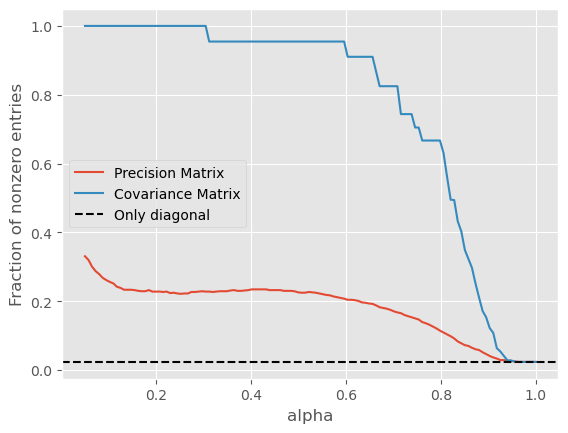

In [10]:
plt.plot(alphas,precision_nonzero/n_features**2,label="Precision Matrix")
plt.plot(alphas,covariance_nonzero/n_features**2,label="Covariance Matrix")
plt.xlabel("alpha")
plt.ylabel("Fraction of nonzero entries")
plt.axhline(1/model.covariance_.shape[0],color='k',linestyle='--',label="Only diagonal")
plt.legend()

On the adni cent low data, seems like the precon matrix and cov matrix go to 0 nonzero entries clost to 1 

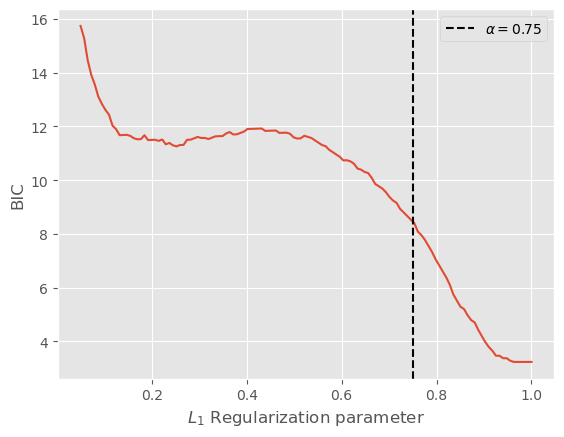

In [11]:
bics = (- 2 * log_likelihoods + ((precision_nonzero - n_features)/2 + n_features) * np.log(n_samples))/n_samples

plt.plot(alphas,bics)
plt.ylabel("BIC")
alpha = 0.75
plt.axvline(alpha,color='k',linestyle='--',label=r"$\alpha="+str(alpha)+"$")
plt.xlabel(r"$L_1$ Regularization parameter")
plt.legend();


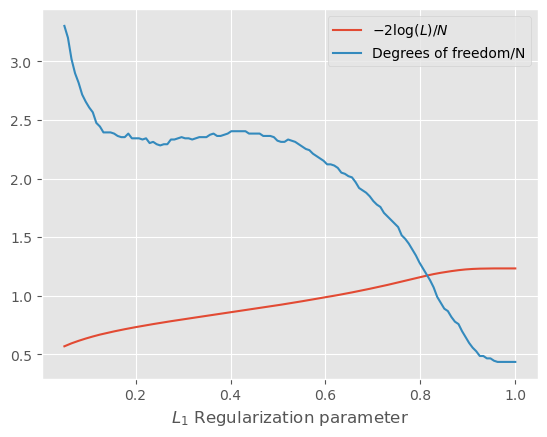

In [12]:
plt.plot(alphas,-2*log_likelihoods/n_samples,label=r'$-2 \log(L)/N$')
plt.plot(alphas,((precision_nonzero - n_features)/2 + n_features)/n_samples,label='Degrees of freedom/N')
plt.legend()
# plt.plot(alphas,bics)
plt.xlabel(r"$L_1$ Regularization parameter");

# Make graphs